# Stereo Depth Estimation

In [1]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from src.dataset.kitti import KITTI
from src.model.SDENet import SDENet

In [2]:
DEVICE = 'cuda:3' if torch.cuda.is_available() else 'cpu'

MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
UNNORM_IMG = T.Normalize((-MEAN/STD).tolist(), (1.0/STD).tolist())

TRAIN_DIR = 'dataset/training'
TEST_DIR = 'dataset/testing'

In [3]:
TRANSFORM = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=MEAN.tolist(), std=STD.tolist())])
TRAIN_BATCH_TRANSFORM = T.RandomCrop((256, 512))

TEST_TRANS =  T.Compose([
    T.ToTensor(),
    T.CenterCrop((376, 1240)),
    T.Normalize(mean=MEAN.tolist(), std=STD.tolist())
])

## Dataset and DataLoader initialization

In [4]:
kitti_train = KITTI(root=TRAIN_DIR, train=True, transform=TRANSFORM, batch_transform=TRAIN_BATCH_TRANSFORM)
kitti_test = KITTI(root=TEST_DIR, train=False, transform=TEST_TRANS)

train_loader = DataLoader(kitti_train, batch_size=4, shuffle=True)
test_loader = DataLoader(kitti_test, batch_size=1, shuffle=True)

## Visualization of training data

In [5]:
def unnorm_sample(left, right):
    left = UNNORM_IMG(left).clip(0,1)
    right = UNNORM_IMG(right).clip(0,1)
    return left, right

In [20]:
def show(left_batch, right_batch, disp_batch, figsize):
    batch_size = left_batch.shape[0]
    _, axs = plt.subplots(nrows=left_batch.shape[0], ncols=1, figsize=figsize)
    for i in range(batch_size):
        left, right, disp = left_batch[i], right_batch[i], disp_batch[i]
        disp = disp.div(256).repeat(3, 1, 1)
        left, right = unnorm_sample(left, right)
        sample = make_grid([left, right, disp], nrow=3)
        axs[i].imshow(F.to_pil_image(sample))
        axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

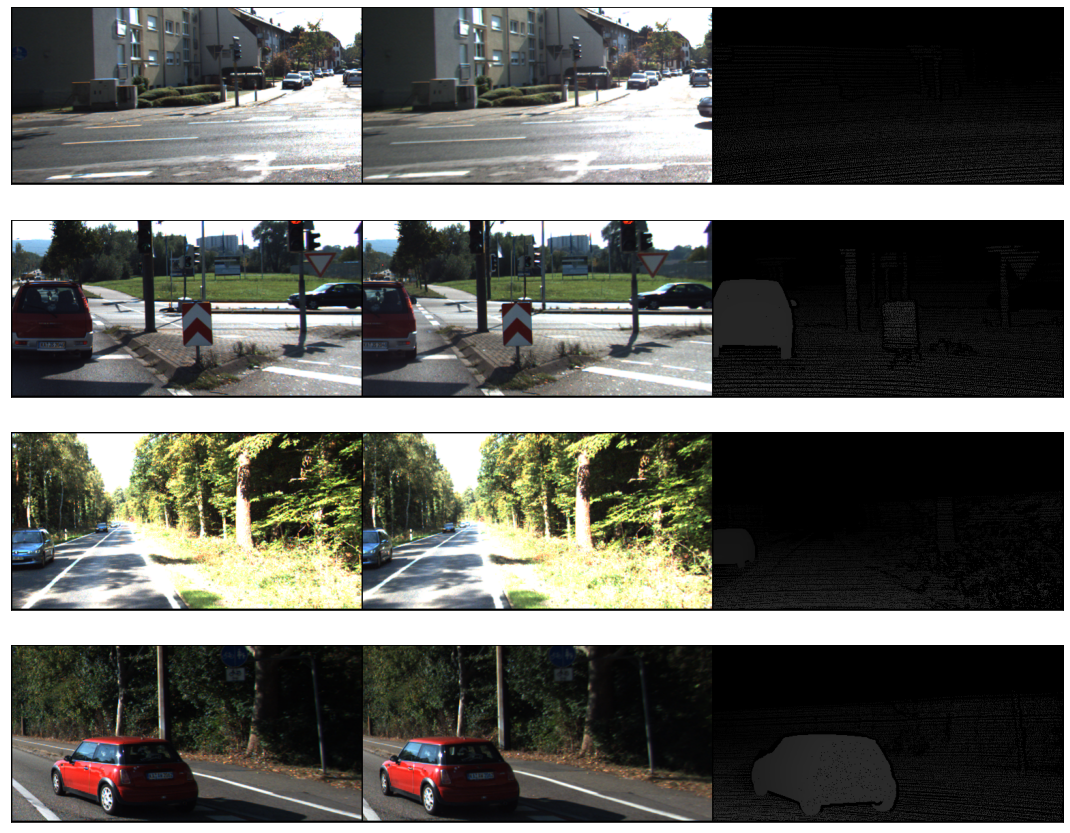

In [21]:
show(*next(iter(train_loader)), figsize=(20,15))

## Loading trained model

In [17]:
resnet2d_inplanes = [32, 40, 39]
resnet3d_inplanes = [18, 27, 20]
SDE_NET = SDENet(resnet2d_inplanes, resnet3d_inplanes)

In [18]:
CKP_PATH = 'checkpoints/2021-09-30_19-50/199.pt'
checkpoint = torch.load(CKP_PATH)

In [23]:
SDE_NET.load_state_dict(checkpoint['state_dict'])
SDE_NET.to(DEVICE)

SDENet(
  (resnet18_2d): ResNet2D(
    (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, trac

## Visualization of predictions

In [25]:
N_PREDICTIONS = 10
left_batch = []
right_batch = []
disp_batch = []

with torch.no_grad():
    for i, (left, right) in enumerate(test_loader):
        if i >= N_PREDICTIONS:
            break
        
        left, right = left.to(DEVICE), right.to(DEVICE)
        disp = SDE_NET(left, right)
        
        left, right, disp = left.squeeze(0).cpu(), right.squeeze(0).cpu(), disp.squeeze(0).cpu()
        left_batch.append(left)
        right_batch.append(right)
        disp_batch.append(disp)
        
        disp = disp.div(256).repeat(3, 1, 1)
        left_unnorm, right_unnorm = unnorm_sample(left, right)
        sample = make_grid([left_unnorm, right_unnorm, disp], nrow=1)

left_batch = torch.stack(left_batch, 0)
right_batch = torch.stack(right_batch, 0)
disp_batch = torch.stack(disp_batch, 0)

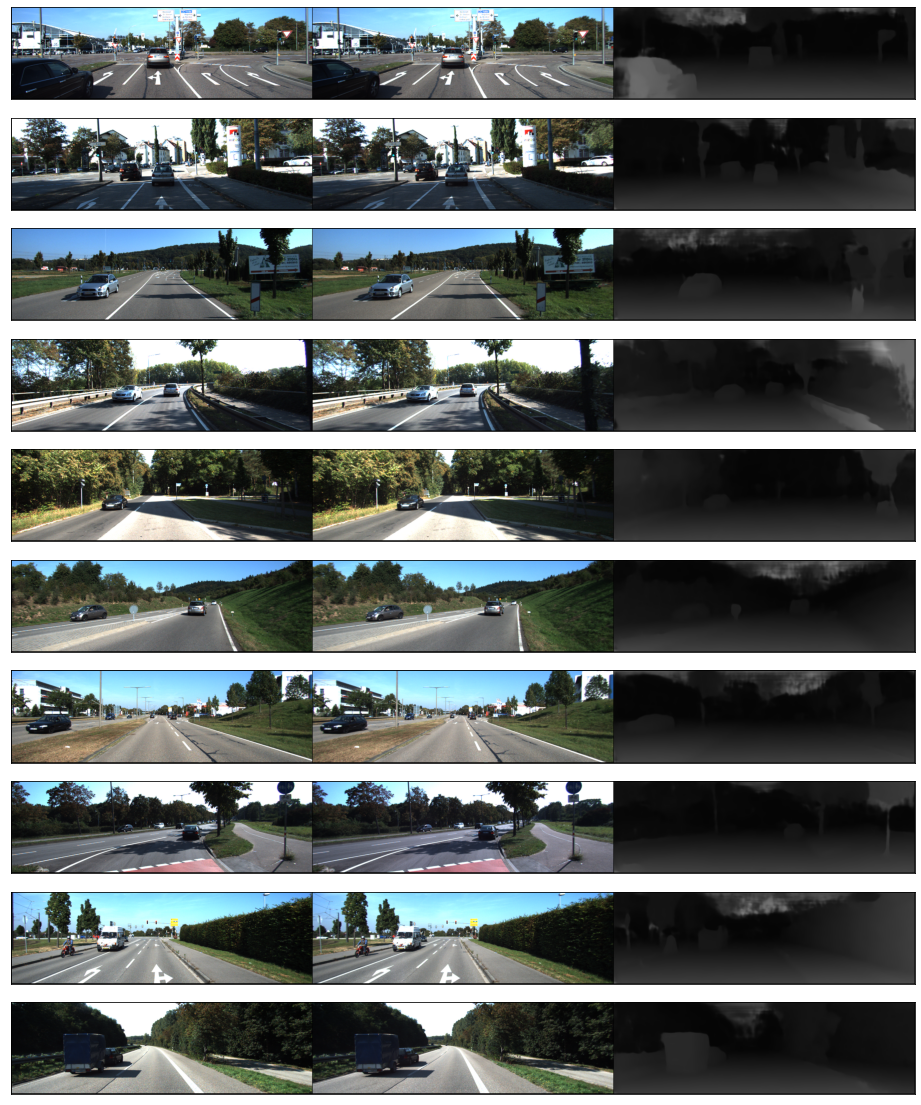

In [26]:
show(left_batch, right_batch, disp_batch, figsize=(20,20))

## Showing predictions in TensorBoard

In [27]:
writer = SummaryWriter('logs/testing')

In [28]:
N_PREDICTIONS = 30
with torch.no_grad():
    for i, (left, right) in enumerate(test_loader):
        if i >= N_PREDICTIONS:
            break
        
        left, right = left.to(DEVICE), right.to(DEVICE)
        disp = SDE_NET(left, right)
        
        left, right, disp = left.squeeze(0).cpu(), right.squeeze(0).cpu(), disp.squeeze(0).cpu()
        disp = disp.div(255).repeat(3, 1, 1)
        left_unnorm, right_unnorm = unnorm_sample(left, right)
        sample = make_grid([left_unnorm, right_unnorm, disp], nrow=1)
        writer.add_image('Test Data', sample, global_step=i)

In [29]:
writer.close()